In [0]:
import tensorflow as tf
from functools import reduce


def tf_kron_prod(a, b):
    res = tf.einsum('ij,ik->ijk', a, b)
    res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
    return res


def tf_bin(x, cut_points, temperature=0.1):
    # x is a N-by-1 matrix (column vector)
    # cut_points is a D-dim vector (D is the number of cut-points)
    # this function produces a N-by-(D+1) matrix, each row has only one element being one and the rest are all zeros
    x
    D = cut_points.get_shape().as_list()[0]
    W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])
    cut_points = tf.contrib.framework.sort(cut_points)  # make sure cut_points is monotonically increasing
    b = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -cut_points], 0))
    h = tf.matmul(x, W) + b
    res = tf.nn.softmax(h / temperature)
    return res


def nn_decision_tree(x, cut_points_list, leaf_score, temperature=0.1):
    # cut_points_list contains the cut_points for each dimension of feature
    leaf = reduce(tf_kron_prod, 
                  map(lambda z: tf_bin(x[:, z[0]:z[0] + 1], z[1], temperature),
                      enumerate(cut_points_list)
                     )
                 )
    return tf.matmul(leaf, leaf_score)

In [0]:
import numpy as np
import tensorflow as tf
# import iris
import matplotlib.pyplot as plt
# from neural_network_decision_tree import nn_decision_tree
%matplotlib inline

In [0]:
tf.__version__

'1.13.1'

In [0]:
np.random.seed(1943)
tf.set_random_seed(1943)

In [0]:
x = feature[:, 2:4]  # use "Petal length" and "Petal width" only
y = label
d = x.shape[1]

In [0]:
num_cut = [1, 3]  # "Petal length" and "Petal width"
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 3

In [0]:
import numpy as np
num_cut = [1,1,1,1]
np.prod(np.array(num_cut) + 1)

16

In [0]:
sess = tf.InteractiveSession()

In [0]:
x_ph = tf.placeholder(tf.float32, [None, d])
y_ph = tf.placeholder(tf.float32, [None, num_class])

In [0]:
cut_points_list = [tf.Variable(tf.random_uniform([i])) for i in num_cut]
leaf_score = tf.Variable(tf.random_uniform([num_leaf, num_class]))

---

In [0]:
from keras import backend as K
keras_cut_points_list = [K.variable(K.random_uniform([i])) for i in num_cut]


In [0]:
keras_cut_points_list[1]

<tf.Variable 'Variable_7:0' shape=(3,) dtype=float32_ref>

In [0]:
D = num_cut[1]

W = tf.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1])

In [0]:
keras_cut_points_list[1] = tf.contrib.framework.sort(keras_cut_points_list[1])

In [0]:
b1 = tf.cumsum(tf.concat([tf.constant(0.0, shape=[1]), -keras_cut_points_list[1]], 0))

In [0]:
x_trial = K.variable(feature[:, 2:4])

In [0]:
x_trial = x_trial[:,1:2]

In [0]:
h1 = tf.matmul(x_trial, W) + b1

In [0]:
b1.eval()

array([ 0.        , -0.05421233, -0.1968565 , -0.67459965], dtype=float32)

In [0]:
tf.matmul(x_trial, W).eval()

In [0]:
h1.eval().shape

(150, 4)

In [0]:
res1 = tf.nn.softmax(h1 / 0.1)

In [0]:
res1.eval()

array([[7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [1.5615430e-03, 4.9578190e-02, 6.5008909e-01, 2.9877117e-01],
       [1.2731146e-02, 1.4869960e-01, 7.1729481e-01, 1.2127436e-01],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [2.7500778e-01, 4.3470868e-01, 2.8379002e-01, 6.4935084e-03],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [7.4648552e-02, 3.2075185e-01, 5.6919670e-01, 3.5402928e-02],
       [2.7500778e-01, 4.3470868e-01, 2.8379002e-01, 6.4935084e-03],
       [2.7500778e-01, 4.3470868e-01, 2.8379002e-01, 6.4935084e-03],
       [7.4648552e-02, 3.2075185e-

In [0]:
res.eval().shape

(150, 2)

In [0]:
## Kron product

kron_prod = tf.einsum('ij,ik->ijk', res, res1)

In [0]:
kron_prod.eval().shape

(150, 2, 4)

In [0]:
kron_reshape = tf.reshape(kron_prod, [-1, tf.reduce_prod(kron_prod.shape[1:])])

In [0]:
kron_reshape.eval().shape

(150, 8)

In [0]:
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 3

In [0]:
leaf_score = tf.Variable(tf.random_uniform([num_leaf, num_class]))

In [0]:
leaf_score.eval().shape

(8, 3)

In [0]:
tf.matmul(kron_reshape, leaf_score).eval()

array([[0.54183924, 0.7063575 , 0.7159359 ],
       [0.54183924, 0.7063575 , 0.7159359 ],
       [0.5418397 , 0.706357  , 0.71593404],
       [0.541839  , 0.7063576 , 0.7159366 ],
       [0.54183924, 0.7063575 , 0.7159359 ],
       [0.7124074 , 0.7908862 , 0.6724133 ],
       [0.7147807 , 0.70385253, 0.7272142 ],
       [0.541839  , 0.7063576 , 0.7159366 ],
       [0.54183924, 0.7063575 , 0.7159359 ],
       [0.30993465, 0.7688037 , 0.65441704],
       [0.541839  , 0.7063576 , 0.7159366 ],
       [0.54183894, 0.70635766, 0.7159368 ],
       [0.30993518, 0.76880336, 0.6544162 ],
       [0.30995172, 0.7687904 , 0.6543906 ],
       [0.541841  , 0.7063556 , 0.7159287 ],
       [0.71240735, 0.7908859 , 0.6724132 ],
       [0.7124068 , 0.79088336, 0.67241263],
       [0.7147807 , 0.70385253, 0.7272142 ],
       [0.7147808 , 0.7038529 , 0.72721493],
       [0.7147807 , 0.70385265, 0.72721463],
       [0.54183894, 0.7063577 , 0.71593696],
       [0.71240735, 0.7908859 , 0.6724132 ],
       [0.

In [0]:
D = cut_points_list[0].get_shape()
D
# result = map(lambda z: print(z), cut_points_list)

TensorShape([Dimension(3)])

In [0]:
for i in enumerate(cut_points_list):
  print(type(i))

<class 'tuple'>
<class 'tuple'>


In [0]:
print(list(result))

<tf.Variable 'Variable:0' shape=(3,) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(3,) dtype=float32_ref>
[None, None]


---

In [0]:
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))

Instructions for updating:
Use tf.cast instead.


In [0]:
opt = tf.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

In [0]:
sess.run(tf.global_variables_initializer())

In [0]:
for i in range(10):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 2 == 0:
        print(loss_e)
print('error rate %.2f' % (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y, axis=1))))

1.3357869
1.1007261
0.8717015
0.6810306
0.5656557
error rate 0.14


In [0]:
np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
y_pred.eval(feed_dict={x_ph: x})

array([[ 1.3554345 , -0.58023655, -0.2665341 ],
       [ 1.3554345 , -0.58023655, -0.2665341 ],
       [ 1.3504598 , -0.6142131 , -0.2829126 ],
       [ 1.3652382 , -0.5132782 , -0.23425646],
       [ 1.3554345 , -0.58023655, -0.2665341 ],
       [ 1.4618584 , -0.24284479, -0.02107989],
       [ 1.2128954 , -0.4644135 , -0.12975815],
       [ 1.3652382 , -0.5132782 , -0.23425646],
       [ 1.3554345 , -0.58023655, -0.2665341 ],
       [ 1.4456677 , -0.59740764, -0.35897985],
       [ 1.3652382 , -0.5132782 , -0.23425646],
       [ 1.3790054 , -0.4192484 , -0.18892893],
       [ 1.4997514 , -0.6909261 , -0.4066546 ],
       [ 1.5432376 , -0.7661196 , -0.4449876 ],
       [ 1.3483645 , -0.62852466, -0.28981152],
       [ 1.2162938 , -0.33673802, -0.04180774],
       [ 1.0773023 , -0.38988227, -0.05353984],
       [ 1.2128954 , -0.4644135 , -0.12975815],
       [ 1.4644998 , -0.30682427, -0.06708103],
       [ 1.2815785 , -0.42139477, -0.11264855],
       [ 1.3913479 , -0.33495015, -0.148

In [0]:
for tf_var in tf.trainable_variables():
    print(tf_var.name,'\n', sess.run(tf_var),'\n')

Variable:0 
 [-0.41340703 -0.2591723   0.09930295] 

Variable_1:0 
 [-0.88486093 -0.88486016  1.1924343 ] 

Variable_2:0 
 [[ 6.4227498e-01 -5.7582057e-04 -2.9063793e-03]
 [ 8.3642191e-01 -1.9713417e-02  6.8874532e-01]
 [ 3.6250135e-01  6.9324660e-01  5.2982438e-01]
 [ 8.3879137e-01 -7.6430753e-02  7.5840253e-01]
 [ 1.1637949e+00 -3.9964584e-01 -1.3457057e-01]
 [ 1.2338103e+00 -2.4644737e-01  1.7020071e-01]
 [ 1.0840871e+00 -1.5334155e-01 -5.2796161e-01]
 [ 1.2378534e+00 -5.6272566e-02 -2.9329711e-01]
 [ 1.0358081e+00 -2.5243816e-01  1.6033120e-01]
 [ 1.5250458e+00 -1.0519429e+00 -3.7126061e-01]
 [ 2.1437163e+00 -9.8507547e-01 -1.1327041e+00]
 [ 2.1126075e+00 -1.3740222e+00 -6.8838656e-01]
 [ 1.5688889e+00 -5.7491148e-01 -3.9931992e-01]
 [ 1.2942290e+00 -5.2697372e-01 -1.0885129e+00]
 [ 1.4011861e+01  1.0327062e+01 -2.9926151e+01]
 [-1.9064920e+01  1.7427883e+01  1.9203033e+01]] 



In [0]:
tf.get_default_graph()

TypeError: Fetch argument <tensorflow.python.framework.ops.Graph object at 0x7f62ba343f98> has invalid type <class 'tensorflow.python.framework.ops.Graph'>, must be a string or Tensor. (Can not convert a Graph into a Tensor or Operation.)

In [0]:
for i in range(1000):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 200 == 0:
        print(loss_e)
print('error rate %.2f' % (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y, axis=1))))

In [0]:
for i in range(1000):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 200 == 0:
        print(loss_e)
print('error rate %.2f' % (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y, axis=1))))

In [0]:
sample_x0 = np.repeat(np.linspace(0, np.max(x[:,0]), 100), 100).reshape(-1,1)
sample_x1 = np.tile(np.linspace(0, np.max(x[:,1]), 100).reshape(-1,1), [100,1])
sample_x = np.hstack([sample_x0, sample_x1])
sample_label = np.argmax(y_pred.eval(feed_dict={x_ph: sample_x}), axis=1)

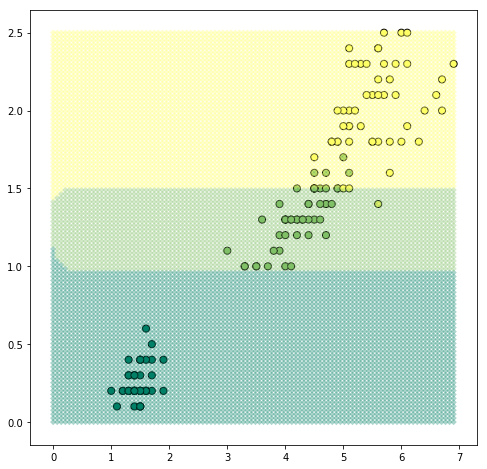

In [0]:
plt.figure(figsize=(8,8))

plt.scatter(x[:,0], 
            x[:,1], 
            c=np.argmax(y, axis=1), 
            marker='o',
            s=50,
            cmap='summer', 
            edgecolors='black')

plt.scatter(sample_x0.flatten(), 
            sample_x1.flatten(), 
            c=sample_label.flatten(), 
            marker='D',
            s=20,
            cmap='summer', 
            edgecolors='none',
            alpha=0.33)

---

## Keras 'layer per feature' implementation

### DNDT Approach 1

In [0]:
from keras.layers import Layer 

class BinningLayer(Layer):

    def __init__(self, feature_num, num_cut, **kwargs):
        self.feature_num = feature_num
        self.num_cut = num_cut
        super(BinningLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.cut_points = self.add_weight(name='cut_points', # Validate this choice of trainable weight.
                                    shape=(self.num_cut,), # Or (self.num_cut,)
                                    initializer='uniform',
                                    trainable=True)
        super(BinningLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        from keras import backend as K # Fix
        import tensorflow as tf
        temperature = 0.1
        X = x[:, self.feature_num - 1 : self.feature_num]
        # D = self.cut_points.get_shape().as_list()[0]
        D = self.num_cut
        W = K.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1]) # find 'K' equivalent of linspace
        self.cut_points = tf.contrib.framework.sort(self.cut_points)  # change tf
        b = K.cumsum(tf.concat([K.constant(0.0, shape=[1]), -self.cut_points], 0))
        h = tf.matmul(X, W) + b
        output = tf.nn.softmax(h / temperature)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_cut+1)

In [0]:
from keras.layers import Layer 

class KronProd(Layer):

    def __init__(self,cut_points_list, **kwargs):
        self.cut_points_list = cut_points_list
#         self.num_class = num_class
        super(KronProd, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
#         self.cut_points = self.add_weight(name='cut_points', # Validate this choice of trainable weight.
#                                     shape=(self.num_cut,), # Or (self.num_cut,)
#                                     initializer='uniform',
#                                     trainable=True)
        super(KronProd, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        from keras import backend as K # Fix
        import tensorflow as tf
        from functools import reduce
        input_tensor_list = x
#         input_tensor_list = []
#         start_point = 0
#         for i in self.cut_points_list:
#           end_point = start_point + i + 1
#           input_tensor_list.append(x[:, start_point:end_point])
#           start_point = end_point
          
        def kron_prod(a,b):
          res = tf.einsum('ij,ik->ijk', a, b)
          res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
          return res
        
        output = reduce(kron_prod, input_tensor_list)
        
        self.output_dim = output.get_shape().as_list()

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim[1])

In [0]:
## Approach 1

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate

visible = Input(shape=(2,)) # For iris with 2 features

hidden1 = BinningLayer(feature_num=1, num_cut=1)(visible)
hidden2 = BinningLayer(feature_num=2, num_cut=3)(visible)
merge = concatenate([hidden1, hidden2])
# kron = KronProd(cut_points_list=[1,1], num_class=4)(merge)
kron = KronProd(cut_points_list=[1,3])([hidden1, hidden2])

output = Dense(3, activation='sigmoid')(kron)
model = Model(inputs=visible, outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
binning_layer_66 (BinningLayer) (None, 2)            1           input_39[0][0]                   
__________________________________________________________________________________________________
binning_layer_67 (BinningLayer) (None, 4)            3           input_39[0][0]                   
__________________________________________________________________________________________________
kron_prod_27 (KronProd)         (None, 8)            0           binning_layer_66[0][0]           
                                                                 binning_layer_67[0][0]           
__________

In [0]:
model.predict(feature[:,2:4])

array([[2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3429966e-01, 2.7111173e-04, 0.0000000e+00],
       [2.3815930e-01, 2.6899576e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.4011937e-01, 2.6786327e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.4011937e-01, 2.6786327e-04, 0.0000000e+00],
       [2.4011937e-01, 2.6786327e-04, 0.0000000e+00],
       [2.3959127e-01, 2.6813149e-04, 0.0000000e+00],
       [2.3429966e-01, 2.7111173e-04, 0.0000000e+00],
       [2.3429966e-01, 2.7111173e-04, 0.0000000e+00],
       [2.3815930e-01, 2.6899576e-04, 0.0000000e+00],
       [2.3815930e-01, 2.689

In [0]:
np.argmax(model.predict(feature[:,2:4]),axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
def keras_softmax_crossentropy(y_true, y_pred):
  return tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_true))

In [0]:
import keras
model.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(feature[:, 2:4], label, epochs=800, batch_size=50)

Epoch 1/800
150/150 [==============================] - 1s 5ms/step - loss: 1.0949 - acc: 0.4333
Epoch 2/800
150/150 [==============================] - 0s 87us/step - loss: 0.9884 - acc: 0.6533
Epoch 3/800
150/150 [==============================] - 0s 84us/step - loss: 0.8698 - acc: 0.6667
Epoch 4/800
150/150 [==============================] - 0s 83us/step - loss: 0.7764 - acc: 0.6667
Epoch 5/800
150/150 [==============================] - 0s 85us/step - loss: 0.6971 - acc: 0.6667
Epoch 6/800
150/150 [==============================] - 0s 74us/step - loss: 0.6250 - acc: 0.6667
Epoch 7/800
150/150 [==============================] - 0s 74us/step - loss: 0.5717 - acc: 0.6667
Epoch 8/800
150/150 [==============================] - 0s 95us/step - loss: 0.5353 - acc: 0.6667
Epoch 9/800
150/150 [==============================] - 0s 74us/step - loss: 0.5132 - acc: 0.6667
Epoch 10/800
150/150 [==============================] - 0s 99us/step - loss: 0.4986 - acc: 0.6667
Epoch 11/800
150/150 [========

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

---

### DNDT Approach 2

In [0]:
from keras.layers import Layer 

class DecisionTrees(Layer):

    def __init__(self, num_cut, **kwargs):
        self.num_cut = num_cut
        super(DecisionTrees, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DecisionTrees, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
      binning_layer_list = []
      for i, value in enumerate(self.num_cut):
        binning_layer_list.append(
            BinningLayer(feature_num=i+1, num_cut=value)(x)
        )

#         merge = concatenate([hidden1, hidden2])
      output = KronProd(cut_points_list=self.num_cut)(binning_layer_list)
      self.output_dim = output.get_shape().as_list()

      return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim[1])

In [0]:
## Approach 2

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

visible = Input(shape=(2,)) # For iris with 2 features

hidden_layer = DecisionTrees(num_cut = [1,3])(visible)

output = Dense(3, activation='sigmoid')(hidden_layer)
model2 = Model(inputs=visible, outputs=output)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
decision_trees_3 (DecisionTr (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 27        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import plot_model
plot_model(model2, to_file='model2.png')

---

### DNDT Approach 3

In [6]:
from keras.layers import Layer
from functools import reduce

class DecisionTrees2(Layer):

    def __init__(self, num_cut, **kwargs):
        self.num_cut = num_cut
        self.cut_points_list = []
#         self.cut_points_dict = {}
        super(DecisionTrees2, self).__init__(**kwargs)

    def build(self, input_shape):
        for i in self.num_cut:
#             if i != 0:
                self.cut_points_list.append(self.add_weight(name='cut_points'+'_'+str(i), # Validate this choice of trainable weight.
                                        shape=(i,), # Or (self.num_cut,)
                                        initializer='random_uniform',
                                        trainable=True))
#                 self.cut_points_dict.update( { i : self.add_weight(name='cut_points'+'_'+str(i), # Validate this choice of trainable weight.
#                                             shape=(i,), # Or (self.num_cut,)
#                                             initializer='uniform',
#                                             trainable=True)} )
#             else:
#                 self.cut_points_list.append(None)
#                 self.cut_points_dict.update( { i : None} )
            
            
#             self.cut_points_list.append(self.add_weight(name='cut_points'+'_'+str(i), # Validate this choice of trainable weight.
#                                         shape=(i,), # Or (self.num_cut,)
#                                         initializer='random_uniform',
#                                         trainable=True))
#         print(self.cut_points_dict)
        super(DecisionTrees2, self).build(input_shape)  # Be sure to call this at the end
        
        
    def bin_fn(self,feature_num, num_cut_value, x):
        from keras import backend as K # Fix
        import tensorflow as tf
        temperature = 0.1
        X = x[:, feature_num - 1 : feature_num]
        # D = self.cut_points.get_shape().as_list()[0]
        D = num_cut_value
        W = K.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1]) # find 'K' equivalent of linspace
        cut_points_value = tf.contrib.framework.sort(self.cut_points_list[feature_num -1])
#         cut_points_value = tf.contrib.framework.sort(self.cut_points_dict[feature_num-1])
        b = K.cumsum(tf.concat([K.constant(0.0, shape=[1]), -cut_points_value], 0))
        h = tf.matmul(X, W) + b
        output = tf.nn.softmax(h / temperature)
        return output

    def call(self, x):
      
      def kron_prod(a,b):
          import tensorflow as tf
          res = tf.einsum('ij,ik->ijk', a, b)
#           res = tf.matmul( a, b)
          res = tf.reshape(res, [-1, tf.reduce_prod(res.shape[1:])])
          return res
      
      binning_layer_list = []
      for i, value in enumerate(self.num_cut):
#         if value != 0:
                print('Value -- ', value)
                binning_layer_list.append(
                    self.bin_fn(feature_num=i+1, num_cut_value=value, x=x)
                )

      output = reduce(kron_prod, binning_layer_list)
      self.output_dim = output.get_shape().as_list()

      return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim[1])

In [16]:
## Approach 3

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

visible = Input(shape=(4,)) # For iris with 2 features

hidden_layer_2 = DecisionTrees2(num_cut = [1,1,1,1])(visible)

output = Dense(3, activation='sigmoid')(hidden_layer_2)
model3 = Model(inputs=visible, outputs=output)
model3.summary()

4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
decision_trees2_3 (DecisionT (None, 16)                4         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import plot_model
plot_model(model3, to_file='model3.png')

In [0]:
import keras
model3.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# cut_dict = {}

cut_dict.update( {0 : 23} )
cut_dict['before']

23

In [0]:
model3.fit(feature[:100,:],label[:100,:], epochs=2, batch_size=50)

Epoch 1/2
100/100 [==============================] - 0s 167us/step - loss: 0.0148 - acc: 1.0000
Epoch 2/2
100/100 [==============================] - 0s 129us/step - loss: 0.0137 - acc: 1.0000


In [0]:
model3.predict(feature[:,2:4])

In [0]:
np.argmax(model3.predict(feature[100:,:]),axis=1)

In [0]:
model3.evaluate(feature[100:,:],label[100:,:])

In [0]:
model3 = None

#### Testing DNDT with Abalone dataset

In [2]:
import pandas as pd
import numpy as np
names = ["sex", "length", "diameter", "height", "whole weight",
        "shucked weight", "viscera weight", "shell weight", "rings"]



data = pd.read_csv('https://s3.ap-south-1.amazonaws.com/mlsquare-datasets/abalone.data.csv',
                   header=None, names=names, index_col=False)

# Check for columns that contain missing values #
col_names = data.columns

num_data = data.shape[0]

categorical_col = ['sex']
for col in categorical_col:
    b, c = np.unique(data[col], return_inverse=True)
    data[col] = c

    
# Filter dataset to contain 'rings' 9 and 10 #
data = data[data['rings'].isin([9,10])]
data['rings'] = data['rings'].map({9: 0, 10: 1})


feature_list = names[:7]
X = data.loc[:, feature_list]
Y = data[['rings']]

In [3]:
import numpy as np
from keras.utils import to_categorical
y_categorical = to_categorical(Y)
y_categorical.shape

(1323, 2)

In [7]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

visible_abalone = Input(shape=(7,)) # For iris with 2 features

hidden_layer_abalone = DecisionTrees2(num_cut = [1,2,3,6,5,3,2])(visible_abalone)

# hidden_layer_abalone = DecisionTrees2(num_cut = [0,1,1])(visible_abalone)

output_abalone = Dense(2, activation='sigmoid')(hidden_layer_abalone)

model_abalone = Model(inputs=visible_abalone, outputs=output_abalone)
model_abalone.summary()

Value --  1
Value --  2
Value --  3
Value --  6
Value --  5
Value --  3
Value --  2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
decision_trees2_2 (DecisionT (None, 12096)             22        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 24194     
Total params: 24,216
Trainable params: 24,216
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 Dimensions must be equal, but are 3 and 2 for 'decision_trees2_6/add' (op: 'Add') with input shapes: [?,3], [2].

In [27]:
hidden_layer_abalone.shape

TensorShape([Dimension(None), Dimension(4320)])

In [9]:
model_abalone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
abalone_history = model_abalone.fit(X.values[:800,:], y_categorical[:800,:], epochs=150)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
800/800 [==============================] - 7s 8ms/step - loss: 0.6928 - acc: 0.5100
Epoch 2/150
800/800 [==============================] - 0s 229us/step - loss: 0.6921 - acc: 0.5225
Epoch 3/150
800/800 [==============================] - 0s 227us/step - loss: 0.6916 - acc: 0.5288
Epoch 4/150
800/800 [==============================] - 0s 239us/step - loss: 0.6909 - acc: 0.5275
Epoch 5/150
800/800 [==============================] - 0s 249us/step - loss: 0.6901 - acc: 0.5262
Epoch 6/150
800/800 [==============================] - 0s 254us/step - loss: 0.6893 - acc: 0.5300
Epoch 7/150
800/800 [==============================] - 0s 244us/step - loss: 0.6885 - acc: 0.5425
Epoch 8/150
800/800 [==============================] - 0s 189us/step - loss: 0.6876 - acc: 0.5450
Epoch 9/150
800/800 [==============================] - 0s 161us/step - loss: 0.6868 - acc: 0.5500
Epoch 10/150
800/800 [==============================] - 0s 173us/step - 

800/800 [==============================] - 0s 228us/step - loss: 0.6696 - acc: 0.5787
Epoch 82/150
800/800 [==============================] - 0s 199us/step - loss: 0.6695 - acc: 0.5800
Epoch 83/150
800/800 [==============================] - 0s 212us/step - loss: 0.6695 - acc: 0.5775
Epoch 84/150
800/800 [==============================] - 0s 200us/step - loss: 0.6693 - acc: 0.5825
Epoch 85/150
800/800 [==============================] - 0s 203us/step - loss: 0.6693 - acc: 0.5813
Epoch 86/150
800/800 [==============================] - 0s 238us/step - loss: 0.6691 - acc: 0.5813
Epoch 87/150
800/800 [==============================] - 0s 220us/step - loss: 0.6692 - acc: 0.5813
Epoch 88/150
800/800 [==============================] - 0s 225us/step - loss: 0.6691 - acc: 0.5825
Epoch 89/150
800/800 [==============================] - 0s 276us/step - loss: 0.6689 - acc: 0.5837
Epoch 90/150
800/800 [==============================] - 0s 269us/step - loss: 0.6689 - acc: 0.5825
Epoch 91/150
800/800 [=

In [11]:
np.unique(np.argmax(model_abalone.predict(X.values[800:,:]), axis=1), return_counts=True)

(array([0, 1]), array([266, 257]))

#### Testing DNDT with covertype dataset

In [0]:
import pandas as pd

data = pd.read_csv("https://s3.ap-south-1.amazonaws.com/mlsquare-datasets/covtype.data.csv",
                   delimiter=",", header=None, index_col=False)
data_copy = data
# data = data[data[54].isin([1,2])]

Y = data.iloc[:, -1]
X = data.iloc[:,:20]

In [0]:
X.shape

(581012, 20)

In [0]:
from keras.utils import to_categorical
y_categorical = to_categorical(Y)

Using TensorFlow backend.


In [0]:
y_categorical.shape

(581012, 8)

In [0]:
# index, count = np.unique(Y, return_counts=True)
# sum(count)

num_cut = [1 for i in range(20)]
len(num_cut)

20

In [0]:
num_cut

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense


visible_covertype = Input(shape=(20,)) # For iris with 2 features

hidden_layer_covertype = DecisionTrees2(num_cut = num_cut)(visible_covertype)

output_covertype = Dense(8, activation='sigmoid')(hidden_layer_covertype)

model_covertype = Model(inputs=visible_covertype, outputs=output_covertype)
model_covertype.summary()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
decision_trees2_1 (DecisionT (None, 1048576)           20        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8388616   
Total params: 8,388,636
Trainable params: 8,388,636
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_covertype.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model_covertype.fit(X.values[:20000,:], y_categorical[:20000,:])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
20000/20000 [==============================] - 972s 49ms/step - loss: 1.8688


In [12]:
temp_dict = {}

for i, value in enumerate([3,3,4]):
    print('i, value = ', i,value)
    temp_dict.update( {i:value} )
    
print(temp_dict)

i, value =  0 3
i, value =  1 3
i, value =  2 4
{0: 3, 1: 3, 2: 4}


In [19]:
temp_dict[]

SyntaxError: invalid syntax (<ipython-input-19-441e3387c204>, line 1)

---

In [0]:
## Quick TODO - 01/05/2019
# 1) Fix Kron layer [X]
# 2) Other changes from yesterdays discussion 
#    + Variable names
#    + Default num_cut and the sealing operation -- 3 different ways to deal with default num_cut
# 3) Test with complete Iris dataset [X]
# 4) Test with Dataset 2 
# 5) Test with Dataset 3 -- by 5:00 pm
# 6) Move to IMLY

## Personal tests -- Not a part of the original repo 

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [0]:
# Python optimisation variables
learning_rate = 0.5
epochs = 10
batch_size = 100

# declare the training data placeholders
# input x - for 28 x 28 pixels = 784
x = tf.placeholder(tf.float32, [None, 784])
# now declare the output data placeholder - 10 digits
y = tf.placeholder(tf.float32, [None, 10])

In [0]:
# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([784, 300], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([300]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([300, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

In [0]:
# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

In [0]:
# now calculate the hidden layer output - in this case, let's use a softmax activated
# output layer
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))

In [0]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

In [0]:
# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [0]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# start the session
with tf.Session() as sess:
   # initialise the variables
   sess.run(init_op)
   total_batch = int(len(mnist.train.labels) / batch_size)
   for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            _, c = sess.run([optimiser, cross_entropy], 
                         feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
   print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

In [0]:
tf.Graph.version

In [0]:
[(np.random_uniform([i])) for i in [1,1]]

## Keras custom layers tests

In [0]:
from keras.layers import Layer 

class BinningFn(Layer): # Move to 'arch/custom_layers'
    from keras import backend as K
    # Move to arch/custom_layers

    def __init__(self, output_dim, num_cut_points, **kwargs):
        from keras import backend as K
        self.output_dim = output_dim
#         kwargs.setdefault('temperature', 0.1)
#         self.temperature = kwargs['temperature']
        self.temperature = 0.1
#         try:
        self.num_cut_points = num_cut_points
        self.cut_points_list = [K.variable(K.random_uniform([i])) for i in self.num_cut_points]
#         except:
#             print('num_cut_points required to create a binning layer')
        super(BinningFn, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
#         self.b = self.add_weight(name='b', # Validate this choice of trainable weight.
#                                     shape=(input_shape[1], self.output_dim),
#                                     initializer='uniform',
#                                     trainable=True)
        super(BinningFn, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        # def binning_fn(x, cut_points, temperature=0.1):
        output = []
        for i in enumerate(self.cut_points_list):
            from keras import backend as K # Fix
            import tensorflow as tf
            X = x[:, i[0]:i[0] + 1]
            cut_points = i[1]
            D = cut_points.get_shape().as_list()[0]
            W = K.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1]) # find 'K' equivalent of linspace
            cut_points = tf.contrib.framework.sort(cut_points)  # change tf
            b = K.cumsum(tf.concat([K.constant(0.0, shape=[1]), -cut_points], 0))
            h = tf.matmul(X, W) + b
            output.append(tf.nn.softmax(h / self.temperature))

        return output

    def compute_output_shape(self, input_shape):
        print (input_shape[0], self.output_dim)
        return (input_shape[0], self.output_dim)

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

---

In [0]:
from keras.layers import Layer 

class CutPnt(Layer):

    def __init__(self, num_cut_points, **kwargs):
#         self.output_dim = output_dim
        import keras.backend as K
        self.num_cut_points = K.variable(num_cut_points)
        super(CutPnt, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
#         self.b = self.add_weight(name='b', # Validate this choice of trainable weight.
#                                     shape=(input_shape[1], self.output_dim),
#                                     initializer='uniform',
#                                     trainable=True)
        super(CutPnt, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        import numpy as np
        print('Shape of x -- ', x)
        import keras.backend as K
        output = K.placeholder(shape=(None, 2, 1))
        output = K.concatenate([x, self.num_cut_points], axis=0)
        output = K.transpose(output)
        print('From call -- ', output)
        return output

    def compute_output_shape(self, input_shape):
#         print (input_shape[0], self.output_dim)
        return (None, 2, 2)

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Lambda

visible = Input(shape=(2,)) # For iris with 2 features
hidden0 = CutPnt(num_cut_points=[[1, 1]])(visible)
# hidden1 = CutPnt()(visible)
# hidden2 = BinningFn(hidden1)
# hidden3 = Kron(hidden2)
# output = Dense()(hidden3)

model = Model(inputs=visible, outputs=hidden0)
model.summary()

Shape of x --  Tensor("input_3:0", shape=(?, 2), dtype=float32)
From call --  Tensor("cut_pnt_3/transpose:0", shape=(2, ?), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
cut_pnt_3 (CutPnt)           (None, 2, 2)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.predict(x)

ValueError: ignored

In [0]:
import numpy as np
x_ = np.array([1.3, 2.3])
num_cuts_ = np.array([1, 1])

np.concatenate(x_, num_cuts_)

TypeError: ignored

In [0]:
K.variable([1,1])

<tf.Variable 'Variable_16:0' shape=(2,) dtype=float32_ref>

In [0]:
test_v = np.concatenate([[[2.3, 3.1]], [[1,1]]], axis=0)

In [0]:
import numpy as np
np.transpose(test_v)

array([[2.3, 1. ],
       [3.1, 1. ]])

In [0]:
test_v.shape

(2, 2)

In [0]:
from keras.layers import Layer 

class BinningFn(Layer): # Move to 'arch/custom_layers'
    from keras import backend as K
    # Move to arch/custom_layers

    def __init__(self, output_dim, num_cut_points, **kwargs):
        from keras import backend as K
        self.output_dim = output_dim
        super(BinningFn, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
#         self.b = self.add_weight(name='b', # Validate this choice of trainable weight.
#                                     shape=(input_shape[1], self.output_dim),
#                                     initializer='uniform',
#                                     trainable=True)
        super(BinningFn, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        X = 
        
        output = tf.matmul(X, W) + b
      
      
        for i in enumerate(self.cut_points_list):
            from keras import backend as K # Fix
            import tensorflow as tf
            X = x[:, i[0]:i[0] + 1]
            cut_points = i[1]
            D = cut_points.get_shape().as_list()[0]
            W = K.reshape(tf.linspace(1.0, D + 1.0, D + 1), [1, -1]) # find 'K' equivalent of linspace
            cut_points = tf.contrib.framework.sort(cut_points)  # change tf
            b = K.cumsum(tf.concat([K.constant(0.0, shape=[1]), -cut_points], 0))
            h = tf.matmul(X, W) + b
            output.append(tf.nn.softmax(h / self.temperature))

        return output

    def compute_output_shape(self, input_shape):
        print (input_shape[0], self.output_dim)
        return (input_shape[0], self.output_dim)

## Replicating Dense layer API by Keras

In [0]:
# Understand the Dense layer API - Read through Keras source code
# Test it - Single layer, functional API call with random inputs
# Create a custom layer that imitates Dense layer
# Test it - Similar inputs and see the output
# Try different combinations and get a hang of the flow and shapes of Tensors involved

In [0]:
## Keras Dense layer

from keras.layers import Dense, Input
from keras.models import Model

visible = Input(shape=(2,)) # For iris with 2 features
hidden = Dense(1)(visible)

model = Model(inputs=visible, outputs=hidden)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
import numpy as np
x = np.array([[1.2, 1.4], [3.3, 4.3], [4.4, 2.1]])
y = np.array([1, 0, 1])

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x, y)
# model.evaluate(x)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
3/3 [==============================] - 1s 206ms/step - loss: 10.7454


In [0]:
model.predict(x)

array([[-2.3984718],
       [-6.9284306],
       [-6.552203 ]], dtype=float32)

In [0]:
hidden

NameError: ignored

---

In [0]:
## Custom dense layer

from keras import backend as K
from keras.layers import Layer

class MyDenseLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyDenseLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [0]:
from keras.layers import Dense, Input
from keras.models import Model

visible = Input(shape=(2,)) # For iris with 2 features
hidden = MyDenseLayer(1)(visible)

model = Model(inputs=visible, outputs=hidden)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
my_dense_layer_3 (MyDenseLay (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x, y)
# model.evaluate(x)

Epoch 1/1
3/3 [==============================] - 0s 49ms/step - loss: 10.7454


In [0]:
model.predict(x)

array([[-0.02561824],
       [-0.08360592],
       [-0.00525406]], dtype=float32)

---

## Plugging sklearn to DNDT

In [1]:
## Import local IMLY

import sys

sys.path.insert(0, "/home/shakkeel/Desktop/mlsquare-core/mlsquare/src")
sys.path

['/home/shakkeel/Desktop/mlsquare-core/mlsquare/src',
 '/home/shakkeel/anaconda3/envs/test_imly/lib/python36.zip',
 '/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6',
 '/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/lib-dynload',
 '',
 '/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages',
 '/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/IPython/extensions',
 '/home/shakkeel/.ipython']

In [2]:
import mlsquare.imly as imly

In [3]:
imly

<module 'mlsquare.imly' from '/home/shakkeel/Desktop/mlsquare-core/mlsquare/src/mlsquare/imly/__init__.py'>

In [25]:
## Tests on sklearn DT

from sklearn.tree import DecisionTreeClassifier

In [26]:
import pandas as pd
import numpy as np

url = "../data/iris.csv"
data = pd.read_csv(url , delimiter=",", header=None, index_col=False)
class_name,index = np.unique(data.iloc[:,-1],return_inverse=True)
data.iloc[:,-1] = index
data = data.loc[data[4] != 2]
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

In [10]:
X.shape

(100, 4)

In [14]:
Y.shape

(100,)

In [27]:
clf = DecisionTreeClassifier(random_state=0)

In [28]:
clf.fit(X.values[:,:], Y.values[:])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [40]:
clf.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [35]:
clf.tree_.children_right

array([-1])

In [36]:
clf.feature_importances_

array([0., 0., 0., 0.])

In [41]:
# Visualize Decision Tree
from sklearn.tree import export_graphviz

# Creates dot file named tree.dot
export_graphviz(
            clf,
            out_file =  "myTreeName.dot",
            feature_names = list(X.columns),
            class_names = None,
            filled = True,
            rounded = True)

In [49]:
import numpy as np
clf.tree_.decision_path(np.float32(X.values))

<100x3 sparse matrix of type '<class 'numpy.int64'>'
	with 200 stored elements in Compressed Sparse Row format>

In [31]:
clf.tree_.feature

[ 3 -2 -2]


In [131]:
clf_2 = DecisionTreeClassifier()
clf_2.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [132]:
# Visualize Decision Tree
from sklearn.tree import export_graphviz

# Creates dot file named tree.dot
export_graphviz(
            clf_2,
            out_file =  "myTreeName2.dot",
            feature_names = list(x.columns),
            class_names = iris.target_names,
            filled = True,
            rounded = True)

In [133]:
feature_index, count = np.unique(clf_2.tree_.feature, return_counts=True)

num_cuts_per_feature = list(np.zeros(shape=max(feature_index+1), dtype=int))
for i,_ in enumerate(num_cuts_per_feature):
    for j,v in enumerate(feature_index):
        if i==v:
            num_cuts_per_feature[i] = count[j]


In [134]:
num_cuts_per_feature

[0, 1, 4, 3]

In [123]:
list(np.zeros(shape=max(feature_index+1)))

[0.0, 0.0, 0.0, 0.0]

In [135]:
print(feature_index)

print(count)

print(num_cuts_per_feature)

max(index)

[-2  1  2  3]
[9 1 4 3]
[0, 1, 4, 3]


3

In [75]:
clf_2.tree_.feature

array([ 2, -2,  3,  2, -2, -2,  2, -2, -2])

In [69]:
list(iris.feature_names)

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [76]:
clf_2.predict(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [89]:
clf_2.__class__.__name__

'DecisionTreeClassifier'

In [91]:
if clf_2.__class__.__name__ is 'DecisionTreeClassifier':
    print('hi')

hi


---

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()
x = pd.DataFrame(iris.data[:, :], columns = iris.feature_names[:])
y = pd.DataFrame(iris.target, columns =["Species"])

## Testing on IMLY

In [2]:
from mlsquare.imly import dope
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from keras.utils import to_categorical
from ray import tune


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

model = DecisionTreeClassifier()

m = dope(model)

y_train = to_categorical(y_train)

params = {
    "epochs": tune.grid_search([100, 200]),
    "optimizer": tune.grid_search(["adam", "nadam"])
}

m.fit(x_train, y_train, cuts_per_feature=2, verbose=1,params=params)


Using TensorFlow backend.


Transpiling your model to it's Deep Neural Network equivalent


2019-05-22 16:56:15,610	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-22_16-56-15_9785/logs.
2019-05-22 16:56:15,717	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:12403 to respond...
2019-05-22 16:56:15,828	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:54193 to respond...
2019-05-22 16:56:15,831	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2019-05-22 16:56:15,849	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.
2019-05-22 16:56:16,950	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-05-22 16:56:16,951	INFO tune.py:211 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.3/8.2 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.3/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_model_1_epochs=200,optimizer=adam:	PENDING
 - train_model_2_epochs=100,optimizer=nadam:	PENDING
 - train_model_3_epochs=200,optimizer=nadam:	PENDING
RUNNING trials:
 - train_model_0_epochs=100,optimizer=adam:	RUNNING

(pid=9907) Using TensorFlow backend.
(pid=9907) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=9907) Instructions for updating:
(pid=9907) Colocations handled automatically by placer.
(pid=9

(pid=9907) 
(pid=9907) 112/112 [==============================] - 0s 45us/step - loss: 1.0688 - acc: 0.3393
(pid=9907) Epoch 44/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 1.0644 - acc: 0.3400
(pid=9907) 112/112 [==============================] - 0s 50us/step - loss: 1.0672 - acc: 0.3571
(pid=9907) Epoch 45/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 1.0678 - acc: 0.5000
(pid=9907) 112/112 [==============================] - 0s 41us/step - loss: 1.0655 - acc: 0.5446
(pid=9907) Epoch 46/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 1.0632 - acc: 0.6000
(pid=9907) 112/112 [==============================] - 0s 49us/step - loss: 1.0638 - acc: 0.5446
(pid=9907) Epoch 47/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 1.0738 - acc: 0.5600
(pid=9907) 112/112 [==============================] - 0s 43us/step - loss: 1.0621 - acc: 0.5446


(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9753 - acc: 0.6800
(pid=9907) 112/112 [==============================] - 0s 44us/step - loss: 0.9789 - acc: 0.6786
(pid=9907) Epoch 92/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9813 - acc: 0.7000
(pid=9907) 112/112 [==============================] - 0s 45us/step - loss: 0.9771 - acc: 0.6786
(pid=9907) Epoch 93/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9659 - acc: 0.7000
(pid=9907) 112/112 [==============================] - 0s 41us/step - loss: 0.9753 - acc: 0.6786
(pid=9907) Epoch 94/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9649 - acc: 0.7000
(pid=9907) 112/112 [==============================] - 0s 40us/step - loss: 0.9735 - acc: 0.6786
(pid=9907) Epoch 95/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9724 - acc: 0.6400
(pid=

(pid=9907) 
(pid=9907) 112/112 [==============================] - 0s 33us/step - loss: 0.9037 - acc: 0.6875
(pid=9907) Epoch 137/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8914 - acc: 0.7000
(pid=9907) 112/112 [==============================] - 0s 39us/step - loss: 0.9022 - acc: 0.6875
(pid=9907) Epoch 138/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8986 - acc: 0.7200
(pid=9907) 112/112 [==============================] - 0s 36us/step - loss: 0.9006 - acc: 0.6875
(pid=9907) Epoch 139/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8840 - acc: 0.7600
(pid=9907) 112/112 [==============================] - 0s 35us/step - loss: 0.8991 - acc: 0.6875
(pid=9907) Epoch 140/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.9047 - acc: 0.7200
(pid=9907) 112/112 [==============================] - 0s 32us/step - loss: 0.8976 - acc: 0.6

(pid=9907) 
(pid=9907) 112/112 [==============================] - 0s 44us/step - loss: 0.8325 - acc: 0.6964
(pid=9907) Epoch 187/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8237 - acc: 0.7000
(pid=9907) 112/112 [==============================] - 0s 39us/step - loss: 0.8312 - acc: 0.6964
(pid=9907) Epoch 188/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8280 - acc: 0.6800
(pid=9907) 112/112 [==============================] - 0s 50us/step - loss: 0.8299 - acc: 0.6964
(pid=9907) Epoch 189/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8303 - acc: 0.6800
(pid=9907) 112/112 [==============================] - 0s 31us/step - loss: 0.8286 - acc: 0.6964
(pid=9907) Epoch 190/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.8330 - acc: 0.7200
(pid=9907) 112/112 [==============================] - 0s 28us/step - loss: 0.8272 - acc: 0.6

(pid=9907) 
(pid=9907) 112/112 [==============================] - 0s 28us/step - loss: 0.7738 - acc: 0.6964
(pid=9907) Epoch 235/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.7965 - acc: 0.6400
(pid=9907) 112/112 [==============================] - 0s 29us/step - loss: 0.7727 - acc: 0.6964
(pid=9907) Epoch 236/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.7819 - acc: 0.6600
(pid=9907) 112/112 [==============================] - 0s 39us/step - loss: 0.7715 - acc: 0.6964
(pid=9907) Epoch 237/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.7918 - acc: 0.6600
(pid=9907) 112/112 [==============================] - 0s 34us/step - loss: 0.7704 - acc: 0.6964
(pid=9907) Epoch 238/250
(pid=9907) 
(pid=9907)  50/112 [============>.................] - ETA: 0s - loss: 0.7751 - acc: 0.6200
(pid=9907) 112/112 [==============================] - 0s 42us/step - loss: 0.7693 - acc: 0.6

2019-05-22 16:56:29,968	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.6383154392242432 seconds to complete, which may be a performance bottleneck.
2019-05-22 16:56:29,973	INFO ray_trial_executor.py:178 -- Destroying actor for trial train_model_0_epochs=100,optimizer=adam. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.8/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_model_1_epochs=200,optimizer=adam:	PENDING
 - train_model_2_epochs=100,optimizer=nadam:	PENDING
 - train_model_3_epochs=200,optimizer=nadam:	PENDING
RUNNING trials:
 - train_model_0_epochs=100,optimizer=adam:	RUNNING, [4 CPUs, 0 GPUs], [pid=9907], 11 s, 1 iter, 0.696 acc

(pid=9979) Using TensorFlow backend.


2019-05-22 16:56:30,558	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.5414144992828369 seconds to complete, which may be a performance bottleneck.


(pid=9979) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=9979) Instructions for updating:
(pid=9979) Colocations handled automatically by placer.
(pid=9979) 
(pid=9979) WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=9979) For more information, please see:
(pid=9979)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=9979)   * https://github.com/tensorflow/addons
(pid=9979) If you depend on functionality not listed there, please file an issue.
(pid=9979) 
(pid=9979) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
(pid=99

(pid=9979) 
(pid=9979) 112/112 [==============================] - 0s 40us/step - loss: 1.0654 - acc: 0.4018
(pid=9979) Epoch 46/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 1.0749 - acc: 0.3400
(pid=9979) 112/112 [==============================] - 0s 37us/step - loss: 1.0639 - acc: 0.4286
(pid=9979) Epoch 47/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 1.0749 - acc: 0.5400
(pid=9979) 112/112 [==============================] - 0s 40us/step - loss: 1.0623 - acc: 0.6071
(pid=9979) Epoch 48/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 1.0639 - acc: 0.6400
(pid=9979) 112/112 [==============================] - 0s 37us/step - loss: 1.0607 - acc: 0.6071
(pid=9979) Epoch 49/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 1.0638 - acc: 0.5800
(pid=9979) 112/112 [==============================] - 0s 34us/step - loss: 1.0589 - acc: 0.6071


(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9458 - acc: 0.7200
(pid=9979) 112/112 [==============================] - 0s 42us/step - loss: 0.9553 - acc: 0.6786
(pid=9979) Epoch 106/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9635 - acc: 0.6400
(pid=9979) 112/112 [==============================] - 0s 30us/step - loss: 0.9536 - acc: 0.6786
(pid=9979) Epoch 107/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9532 - acc: 0.6800
(pid=9979) 112/112 [==============================] - 0s 39us/step - loss: 0.9520 - acc: 0.6786
(pid=9979) Epoch 108/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9460 - acc: 0.7200
(pid=9979) 112/112 [==============================] - 0s 51us/step - loss: 0.9503 - acc: 0.6786
(pid=9979) Epoch 109/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9369 - acc: 0.7600
(

(pid=9979) 112/112 [==============================] - 0s 31us/step - loss: 0.8884 - acc: 0.6875
(pid=9979) Epoch 149/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8918 - acc: 0.6200
(pid=9979) 112/112 [==============================] - 0s 46us/step - loss: 0.8869 - acc: 0.6875
(pid=9979) Epoch 150/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.9087 - acc: 0.5600
(pid=9979) 112/112 [==============================] - 0s 40us/step - loss: 0.8854 - acc: 0.6875
(pid=9979) Epoch 151/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8683 - acc: 0.7600
(pid=9979) 112/112 [==============================] - 0s 46us/step - loss: 0.8840 - acc: 0.6875
(pid=9979) Epoch 152/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8954 - acc: 0.6400
(pid=9979) 
(pid=9979) 112/112 [==============================] - 0s 37us/step - loss: 0.8825 - acc: 0.6

(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8217 - acc: 0.7400
(pid=9979) 112/112 [==============================] - 0s 29us/step - loss: 0.8379 - acc: 0.6964
(pid=9979) Epoch 185/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8471 - acc: 0.6600
(pid=9979) 112/112 [==============================] - 0s 44us/step - loss: 0.8366 - acc: 0.6964
(pid=9979) Epoch 186/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8503 - acc: 0.6200
(pid=9979) 112/112 [==============================] - 0s 36us/step - loss: 0.8352 - acc: 0.6964
(pid=9979) Epoch 187/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8649 - acc: 0.5800
(pid=9979) 112/112 [==============================] - 0s 41us/step - loss: 0.8339 - acc: 0.6964
(pid=9979) Epoch 188/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.8265 - acc: 0.7000
(

(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.7765 - acc: 0.6800
(pid=9979) 112/112 [==============================] - 0s 50us/step - loss: 0.7830 - acc: 0.6964
(pid=9979) Epoch 229/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.7956 - acc: 0.7000
(pid=9979) 112/112 [==============================] - 0s 51us/step - loss: 0.7818 - acc: 0.6964
(pid=9979) Epoch 230/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.7756 - acc: 0.6800
(pid=9979) 112/112 [==============================] - 0s 31us/step - loss: 0.7807 - acc: 0.6964
(pid=9979) Epoch 231/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.7615 - acc: 0.7000
(pid=9979) 112/112 [==============================] - 0s 39us/step - loss: 0.7795 - acc: 0.6964
(pid=9979) Epoch 232/250
(pid=9979) 
(pid=9979)  50/112 [============>.................] - ETA: 0s - loss: 0.7714 - acc: 0.6800
(

2019-05-22 16:56:36,493	WARNING util.py:62 -- The `experiment_checkpoint` operation took 1.1087863445281982 seconds to complete, which may be a performance bottleneck.
2019-05-22 16:56:36,496	INFO ray_trial_executor.py:178 -- Destroying actor for trial train_model_1_epochs=200,optimizer=adam. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.7/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'TERMINATED': 1, 'RUNNING': 1, 'PENDING': 2})
PENDING trials:
 - train_model_2_epochs=100,optimizer=nadam:	PENDING
 - train_model_3_epochs=200,optimizer=nadam:	PENDING
RUNNING trials:
 - train_model_1_epochs=200,optimizer=adam:	RUNNING, [4 CPUs, 0 GPUs], [pid=9979], 5 s, 1 iter, 0.696 acc
TERMINATED trials:
 - train_model_0_epochs=100,optimizer=adam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9907], 11 s, 1 iter, 0.696 acc



2019-05-22 16:56:36,845	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.34825754165649414 seconds to complete, which may be a performance bottleneck.


(pid=9980) Using TensorFlow backend.
(pid=9980) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=9980) Instructions for updating:
(pid=9980) Colocations handled automatically by placer.
(pid=9980) 
(pid=9980) WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=9980) For more information, please see:
(pid=9980)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=9980)   * https://github.com/tensorflow/addons
(pid=9980) If you depend on functionality not listed there, please file an issue.
(pid=9980) 
(pid=9980) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be

(pid=9980) 
(pid=9980) 112/112 [==============================] - 0s 40us/step - loss: 0.9924 - acc: 0.6429
(pid=9980) Epoch 39/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.9768 - acc: 0.7000
(pid=9980) 112/112 [==============================] - 0s 32us/step - loss: 0.9882 - acc: 0.6429
(pid=9980) Epoch 40/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.9800 - acc: 0.6600
(pid=9980) 112/112 [==============================] - 0s 38us/step - loss: 0.9843 - acc: 0.6429
(pid=9980) Epoch 41/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.9657 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 40us/step - loss: 0.9804 - acc: 0.6429
(pid=9980) Epoch 42/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.9716 - acc: 0.6600
(pid=9980) 112/112 [==============================] - 0s 55us/step - loss: 0.9766 - acc: 0.6429


(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.8583 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 40us/step - loss: 0.8474 - acc: 0.6875
(pid=9980) Epoch 83/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.8590 - acc: 0.6600
(pid=9980) 112/112 [==============================] - 0s 43us/step - loss: 0.8445 - acc: 0.6875
(pid=9980) Epoch 84/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.8508 - acc: 0.6400
(pid=9980) 112/112 [==============================] - 0s 47us/step - loss: 0.8417 - acc: 0.6875
(pid=9980) Epoch 85/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.8055 - acc: 0.8400
(pid=9980) 112/112 [==============================] - 0s 42us/step - loss: 0.8391 - acc: 0.6875
(pid=9980) Epoch 86/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.8481 - acc: 0.6600
(pid=

(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.7252 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 34us/step - loss: 0.7360 - acc: 0.6964
(pid=9980) Epoch 129/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.7402 - acc: 0.8000
(pid=9980) 112/112 [==============================] - 0s 36us/step - loss: 0.7340 - acc: 0.6964
(pid=9980) Epoch 130/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.7335 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 33us/step - loss: 0.7319 - acc: 0.6964
(pid=9980) Epoch 131/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.7238 - acc: 0.6400
(pid=9980) 112/112 [==============================] - 0s 44us/step - loss: 0.7299 - acc: 0.6964
(pid=9980) Epoch 132/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.7052 - acc: 0.7400
(

(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6596 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 38us/step - loss: 0.6456 - acc: 0.6964
(pid=9980) Epoch 186/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6729 - acc: 0.7000
(pid=9980) 112/112 [==============================] - 0s 31us/step - loss: 0.6444 - acc: 0.6964
(pid=9980) Epoch 187/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6707 - acc: 0.6600
(pid=9980) 112/112 [==============================] - 0s 38us/step - loss: 0.6432 - acc: 0.6964
(pid=9980) Epoch 188/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6494 - acc: 0.6800
(pid=9980) 112/112 [==============================] - 0s 36us/step - loss: 0.6420 - acc: 0.6964
(pid=9980) Epoch 189/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6123 - acc: 0.7000
(

(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.5740 - acc: 0.7800
(pid=9980) 112/112 [==============================] - 0s 34us/step - loss: 0.5971 - acc: 0.6964
(pid=9980) Epoch 234/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6087 - acc: 0.6400
(pid=9980) 112/112 [==============================] - 0s 31us/step - loss: 0.5963 - acc: 0.6964
(pid=9980) Epoch 235/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.5863 - acc: 0.7400
(pid=9980) 112/112 [==============================] - 0s 37us/step - loss: 0.5954 - acc: 0.6964
(pid=9980) Epoch 236/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6244 - acc: 0.7200
(pid=9980) 112/112 [==============================] - 0s 38us/step - loss: 0.5946 - acc: 0.6964
(pid=9980) Epoch 237/250
(pid=9980) 
(pid=9980)  50/112 [============>.................] - ETA: 0s - loss: 0.6629 - acc: 0.6400
(

2019-05-22 16:56:41,646	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.16126680374145508 seconds to complete, which may be a performance bottleneck.
2019-05-22 16:56:41,649	INFO ray_trial_executor.py:178 -- Destroying actor for trial train_model_2_epochs=100,optimizer=nadam. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.7/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'TERMINATED': 2, 'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_model_3_epochs=200,optimizer=nadam:	PENDING
RUNNING trials:
 - train_model_2_epochs=100,optimizer=nadam:	RUNNING, [4 CPUs, 0 GPUs], [pid=9980], 4 s, 1 iter, 0.696 acc
TERMINATED trials:
 - train_model_0_epochs=100,optimizer=adam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9907], 11 s, 1 iter, 0.696 acc
 - train_model_1_epochs=200,optimizer=adam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9979], 5 s, 1 iter, 0.696 acc



2019-05-22 16:56:42,150	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.49997615814208984 seconds to complete, which may be a performance bottleneck.


(pid=9982) Using TensorFlow backend.


2019-05-22 16:56:42,669	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.5099198818206787 seconds to complete, which may be a performance bottleneck.


(pid=9982) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
(pid=9982) Instructions for updating:
(pid=9982) Colocations handled automatically by placer.
(pid=9982) 
(pid=9982) WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
(pid=9982) For more information, please see:
(pid=9982)   * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
(pid=9982)   * https://github.com/tensorflow/addons
(pid=9982) If you depend on functionality not listed there, please file an issue.
(pid=9982) 
(pid=9982) WARNING:tensorflow:From /home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
(pid=99

(pid=9982) 
(pid=9982) 112/112 [==============================] - 0s 89us/step - loss: 0.9956 - acc: 0.6429
(pid=9982) Epoch 42/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.9924 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 38us/step - loss: 0.9920 - acc: 0.6429
(pid=9982) Epoch 43/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.9808 - acc: 0.7200
(pid=9982) 112/112 [==============================] - 0s 43us/step - loss: 0.9883 - acc: 0.6429
(pid=9982) Epoch 44/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.9848 - acc: 0.6800
(pid=9982) 112/112 [==============================] - 0s 32us/step - loss: 0.9844 - acc: 0.6429
(pid=9982) Epoch 45/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.9902 - acc: 0.6200
(pid=9982) 112/112 [==============================] - 0s 36us/step - loss: 0.9807 - acc: 0.6518


(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.8544 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 57us/step - loss: 0.8319 - acc: 0.6875
(pid=9982) Epoch 88/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.8224 - acc: 0.7200
(pid=9982) 112/112 [==============================] - 0s 50us/step - loss: 0.8286 - acc: 0.6875
(pid=9982) Epoch 89/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.8076 - acc: 0.7000
(pid=9982) 112/112 [==============================] - 0s 39us/step - loss: 0.8251 - acc: 0.6875
(pid=9982) Epoch 90/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.8309 - acc: 0.7200
(pid=9982) 112/112 [==============================] - 0s 50us/step - loss: 0.8217 - acc: 0.6875
(pid=9982) Epoch 91/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.8410 - acc: 0.6200
(pid=

(pid=9982) 
(pid=9982) 112/112 [==============================] - 0s 31us/step - loss: 0.7137 - acc: 0.6964
(pid=9982) Epoch 132/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.7448 - acc: 0.6200
(pid=9982) 112/112 [==============================] - 0s 33us/step - loss: 0.7118 - acc: 0.6964
(pid=9982) Epoch 133/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.7201 - acc: 0.6800
(pid=9982) 112/112 [==============================] - 0s 36us/step - loss: 0.7098 - acc: 0.6964
(pid=9982) Epoch 134/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.7203 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 34us/step - loss: 0.7079 - acc: 0.6964
(pid=9982) Epoch 135/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.7291 - acc: 0.7000
(pid=9982) 112/112 [==============================] - 0s 31us/step - loss: 0.7060 - acc: 0.6

(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.6379 - acc: 0.7200
(pid=9982) 112/112 [==============================] - 0s 36us/step - loss: 0.6272 - acc: 0.6964
(pid=9982) Epoch 189/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.6546 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 35us/step - loss: 0.6260 - acc: 0.6964
(pid=9982) Epoch 190/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.5892 - acc: 0.7200
(pid=9982) 112/112 [==============================] - 0s 40us/step - loss: 0.6249 - acc: 0.6964
(pid=9982) Epoch 191/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.6425 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 50us/step - loss: 0.6238 - acc: 0.6964
(pid=9982) Epoch 192/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.6404 - acc: 0.6800
(

(pid=9982) 
(pid=9982) 112/112 [==============================] - 0s 32us/step - loss: 0.5776 - acc: 0.6964
(pid=9982) Epoch 245/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.5718 - acc: 0.7600
(pid=9982) 112/112 [==============================] - 0s 43us/step - loss: 0.5770 - acc: 0.6964
(pid=9982) Epoch 246/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.5710 - acc: 0.6400
(pid=9982) 112/112 [==============================] - 0s 59us/step - loss: 0.5764 - acc: 0.6964
(pid=9982) Epoch 247/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.5633 - acc: 0.7400
(pid=9982) 112/112 [==============================] - 0s 44us/step - loss: 0.5757 - acc: 0.6964
(pid=9982) Epoch 248/250
(pid=9982) 
(pid=9982)  50/112 [============>.................] - ETA: 0s - loss: 0.5643 - acc: 0.6600
(pid=9982) 112/112 [==============================] - 0s 42us/step - loss: 0.5751 - acc: 0.6

2019-05-22 16:56:46,763	INFO ray_trial_executor.py:178 -- Destroying actor for trial train_model_3_epochs=200,optimizer=nadam. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for train_model_3_epochs=200,optimizer=nadam:
  checkpoint: 'weights_tune_{''epochs'': 200, ''optimizer'': ''nadam'', ''units'': 3,
    ''cuts_per_feature'': 2}.h5'
  date: 2019-05-22_16-56-46
  done: false
  experiment_id: 2503afe5b61945fda6a05f0dc6b0cc9e
  hostname: shakkeel-TUF-GAMING-FX504GD-FX80GD
  iterations_since_restore: 1
  mean_accuracy: 0.6964285714285714
  node_ip: 192.168.43.199
  pid: 9982
  time_since_restore: 4.454753398895264
  time_this_iter_s: 4.454753398895264
  time_total_s: 4.454753398895264
  timestamp: 1558524406
  timesteps_since_restore: 0
  training_iteration: 1
  
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.7/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'TERMINATED': 3, 'RUNNING': 1})
RUNNING trials:
 - train_model_3_epochs=200,optimizer=nadam:	RUNNING, [4 CPUs, 0 GPUs], [pid=9982], 4 s, 1 iter, 0.696 acc
TERMINATED trials:
 - train_model_

2019-05-22 16:56:47,281	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.5170235633850098 seconds to complete, which may be a performance bottleneck.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.5/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'TERMINATED': 4})
TERMINATED trials:
 - train_model_0_epochs=100,optimizer=adam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9907], 11 s, 1 iter, 0.696 acc
 - train_model_1_epochs=200,optimizer=adam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9979], 5 s, 1 iter, 0.696 acc
 - train_model_2_epochs=100,optimizer=nadam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9980], 4 s, 1 iter, 0.696 acc
 - train_model_3_epochs=200,optimizer=nadam:	TERMINATED, [4 CPUs, 0 GPUs], [pid=9982], 4 s, 1 iter, 0.696 acc

Creating model...
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an i

In [5]:
from mlsquare.imly import dope
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from ray import tune


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

model = LogisticRegression()

m = dope(model)

# y_train = to_categorical(y_train)

params = {
    "epochs": tune.grid_search([100, 200]),
    "optimizer": tune.grid_search(["adam", "nadam"])
}

m.fit(x_train, y_train,verbose=1,params=params)

Using TensorFlow backend.


Transpiling your model to it's Deep Neural Network equivalent


2019-05-10 18:07:42,828	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-10_18-07-42_2723/logs.
2019-05-10 18:07:42,939	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:28327 to respond...
2019-05-10 18:07:43,051	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:35787 to respond...
2019-05-10 18:07:43,054	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2019-05-10 18:07:43,095	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


self.params from __init__ --  None
Instructions for updating:
Colocations handled automatically by placer.


/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
2019-05-10 18:07:43,505	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-05-10 18:07:43,513	INFO tune.py:211 -- Starting a new experiment.


self.params from fit --  None
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.2/8.2 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.2/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_model_1_epochs=200,optimizer=adam:	PENDING
 - train_model_2_epochs=100,optimizer=nadam:	PENDING
 - train_model_3_epochs=200,optimizer=nadam:	PENDING
RUNNING trials:
 - train_model_0_epochs=100,optimizer=adam:	RUNNING

(pid=2783) 2019-05-10 18:07:48,345	ERROR function_manager.py:723 -- Failed to load actor class %s.
(pid=2783) Traceback (most recent call last):
(pid=2783)   File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/ray/function_manager.py", line 720, in _load_actor_class_from_gcs
(pid=2783)     actor_class = pickle.loads(pickled_class)
(pid=2783) Mod

2019-05-10 18:08:01,812	ERROR trial_runner.py:460 -- Error processing event.
Traceback (most recent call last):
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/ray/tune/trial_runner.py", line 409, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/ray/tune/ray_trial_executor.py", line 314, in fetch_result
    result = ray.get(trial_future[0])
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/ray/worker.py", line 2316, in get
    raise value
ray.exceptions.RayTaskError: ray_TemporaryActor:train() (pid=2783, host=shakkeel-TUF-GAMING-FX504GD-FX80GD)
Exception: The actor with name WrappedFunc failed to be imported, and so cannot execute this method.

2019-05-10 18:08:01,815	ERROR worker.py:1780 -- Failed to unpickle actor class 'WrappedFunc' for actor ID 7d5c80a44cbdc793fe951c0cbda829050d563e22. Traceback:
Traceback (most recent call last):
 

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/0 GPUs
Memory usage on this node: 4.4/8.2 GB
Result logdir: /home/shakkeel/ray_results/experiment_name
Number of trials: 4 ({'ERROR': 1, 'PENDING': 3})
ERROR trials:
 - train_model_0_epochs=100,optimizer=adam:	ERROR, 1 failures: /home/shakkeel/ray_results/experiment_name/train_model_0_epochs=100,optimizer=adam_2019-05-10_18-07-43jcvfvsml/error_2019-05-10_18-08-01.txt
PENDING trials:
 - train_model_1_epochs=200,optimizer=adam:	PENDING
 - train_model_2_epochs=100,optimizer=nadam:	PENDING
 - train_model_3_epochs=200,optimizer=nadam:	PENDING



2019-05-10 18:08:03,110	WARNING util.py:62 -- The `experiment_checkpoint` operation took 0.6360447406768799 seconds to complete, which may be a performance bottleneck.
Exception in thread ray_import_thread:
Traceback (most recent call last):
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/redis/connection.py", line 185, in _read_from_socket
    raise socket.error(SERVER_CLOSED_CONNECTION_ERROR)
OSError: Connection closed by server.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shakkeel/anaconda3/envs/test_imly/lib/python3.6/site-packages/ray/import_thread.py", line 70, in _run
    msg = import_pubsub_client.get_message()
  File "

KeyboardInterrupt: 

In [8]:
mlsquar

<module 'mlsquare' from '/home/shakkeel/Desktop/mlsquare-core/mlsquare/src/mlsquare/__init__.py'>

In [7]:
y_test = to_categorical(y_test)

m.score(x_test, y_test)

38/38 [==============================] - 0s 2ms/step


[0.7709232882449502, 0.5789473715581392]

In [8]:
m.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
decision_tree_3 (DecisionTre (None, 81)                8         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 246       
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


In [9]:
m.model.metrics_names

['loss', 'acc']

In [179]:
from keras.utils import to_categorical

to_categorical(y_train).shape

(112, 3)

In [9]:
def dummy():
    pass

dummy.__name__

'dummy'

In [2]:

import numpy as np

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

feature_index, count = np.array([0,1,2,3]), np.array([0,2,1,4])
cuts_per_feature = np.zeros(shape=x_train.shape[1], dtype=int)
# for i, value in enumerate(count):
#     if value < 1:
#         cuts_per_feature[i] = 1
#     elif value > np.ceil(150):
#         cuts_per_feature[i] = np.ceil(150) ## Convert to list comprehension
#     else:
#         cuts_per_feature[i] = count[i]

In [4]:
cuts_per_feature = [count[j] for i,_ in enumerate(cuts_per_feature)
                    for j, value in enumerate(feature_index) if i==value]

In [5]:
cuts_per_feature

[0, 2, 1, 4]

In [52]:
l = [1, 2, 3, 4, 5]
['yes' if v == 1 else 'no' if v == 2 else 'idle' for v in l]

['yes', 'no', 'idle', 'idle', 'idle']

In [6]:
cuts_per_feature = [1 if value < 1 else np.ceil(x_train.shape[0]) if value > np.ceil(x_train.shape[0]) else count[i]
                    for i, value in enumerate(count)]

In [7]:
cuts_per_feature

[1, 2, 1, 4]

In [13]:
cuts_per_feature = [ 1 if i != value else np.ceil(x_train.shape[0]) if count[j] > np.ceil(x_train.shape[0])
                    else count[j]
                    for i in range(x_train.shape[1])
                    for j, value in enumerate(feature_index) ]

In [11]:
x_train.shape[1]

4

In [16]:
cuts_per_feature = None

In [ ]:
test_cuts = []

for i in range(x_train.shape[1]):
    for j, value in enumerate(feature_index):
        if i != value:
            test_cuts.append(1)
        elif count[j] > np.ceil(x_train.shape[0]):
            test_cuts.append(np.ceil(x_train[0]))
        else:
            test_cuts.append()

In [18]:
rrr = []
if not rrr:
    print('hi')
else:
    print('nnn')

hi


In [38]:
rrrr = 3
if type(rrrr) not in (list, int):
            raise TypeError('cuts_per_feature should be of type `list` or `int`')

In [45]:
all(isinstance(n, int) for n in [1,2.5,3])

False

In [10]:


if all(isinstance(n, int) for n in [1, 1, 2, 2]):
    print('hi')

hi


In [5]:
m.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
decision_tree_3 (DecisionTre (None, 81)                8         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 246       
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________
